# Figure 3 - Vergilian Borrowing

## Rationale

The LSA study tries to capture general lexico-grammatical style. This study looks specifically at lines that are directly modelled on lines from the _Aeneid_. The key difference is that an "intertextual match" here is a single line that shares two or more semantic words (ie non stopwords) with one other line in the _Aeneid_. The aim of this study was to objectively test the intuition of seveal scholars who observed that the Vergilian borrowings 'seemed to increase' in the _Additamentum_, with the general implication being EITHER that the interpolation was composed by a poet who bolstered the quality of their work essentially by cribbing from Vergil OR that the composer was aware of Silius' habit of Vergilian borrowing and overplayed their hand while attempting to imitate it. 

## Method

The intertextual matches were found using Tesserae v3 (the precise settings are described below). We used our own stopword list, which is more comprehensive than the Tesserae list. The Tesserae web results were then exported as CSV and are preprocessed here in Python (the raw data is included in this repository). Each line can match more than one line in the comparison text (the _Aeneid_), and so we simply take the highest score per line. If there is a deliberate model for a given line, we must hope that the score for the 'real' model will be as high or higher than the best false positive. Finally, the score for a chunk (81 lines) is just the sum of the per-line score. The general operation and core algorithms of Tesserae v3 are described in this [DSH paper](https://academic.oup.com/dsh/article-abstract/28/2/221/1033788). We note that the site has recently updated to new code. For now, the version used in this study can still be accessed [here](https://tesseraev3.caset.buffalo.edu/).

Once the per-chunk scores have been collected, we verify (using a QQ plot) that the scores are normally distributed, and so we base our claim of abnormality on the fact that the score for the _Additamentum_ is further than 3 standard deviations from the mean.

## Limitations

Not all lines with a Tesserae match score over 8 (our chosen cutoff) will be 'genuine' intertextual matches in the sense that there is a semantic similarity between the lines more broadly that would be considered deliberately allusive by a human expert. See the Tesserae paper (above) for more on this. This kind of holistic analysis is beyond the lexical matching approach that Tesserae performs, and probably beyond the present state of the art (on which see [Manjavacas, Long and Kestemont](https://www.aclweb.org/anthology/W19-2514/). 

We are explicitly not setting out to detect only 'true' allusion, although we hope that most of those allusions will be included in the results. An interpolator might well choose a model line based simply on a word they need or a useful trick of scansion, without caring about the 'art' of their allusion (and without neccessarily intending that the imitation be detected, whereas 'genuine' allusion cannot activate without detection).

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import re
import math
import csv
import matplotlib.pyplot as plt
from mqdq import hexameter_corpus
from mqdq import utils
from bs4 import BeautifulSoup

In [3]:
%%capture
%load_ext rpy2.ipython

In [4]:
# Some quick utility functions

In [5]:
def import_from_tess(fn):
    with open(fn, newline='') as csvfile:
        # strip leading blank lines
        while True:
            l = csvfile.readline()
            if len(l.strip()) > 0:
                break
        # strip commented header
        while True:
            l = csvfile.readline()
            if not l.startswith('#'):
                break
        reader = csv.reader(csvfile)
        headers = next(reader, None)
        lines = [row for row in reader]
    return(headers, lines)

In [6]:
def pandafy(h, ll):
    df = pd.DataFrame(ll)
    df.columns = h
    df = df[df.apply(lambda x: not has_stop(x['SHARED']), axis=1)]
    df[['SCORE', 'OTHER_TEXTS', 'OTHER_TOTAL']] = df[['SCORE', 'OTHER_TEXTS', 'OTHER_TOTAL']].apply(pd.to_numeric)
    # after index 8 it's per-text comparison scores which we don't need
    return df[h[:9]]

In [8]:
def br(s):
    '''
    convert a bookref string to a tuple of (booknum, linenum)
    '''
    
    return re.search('\d+\.\d+', s).group()

In [9]:
def find_idx(s, puni_df):
    
    '''
    Find the 0 based index of the given bookref in the
    Punica dataframe. Best effort (don't die on failure).
    '''
    
    b,l = [int(x) for x in br(s).split('.')]
    
    try:
        return int(puni_df.loc[(puni_df['Book']==b) & (puni_df['LN']==l)].iloc[0].name)
    except:
        pass

These are the Tesserae settings that were used:

```		
session   = 100041cf		
source    = vergil.aeneid		
target    = silius_italicus.punica		
unit      = line		
feature   = stem		
stopsize  = 0		
stbasis   = corpus		
stopwords = 		
max_dist  = 999		
dibasis   = freq		
cutoff    = 8		
m_cutoff  = 6		
filter    = off
```

Tesserae is able to strip some stopwords, but not as many as we'd like.
We replace their stopword stripping with our own.
Matches that would not be matches without matching on a stopword are
considered to be false positives and are removed below.

In [11]:
# http://www.perseus.tufts.edu/hopper/stopwords
stops = '''a, ab, ac, ad, adhic, aliqui, aliquis, an, ante, apud, at, atque, aut, \
autem, cum, cur, de, deinde, dum, ego, enim, ergo, es, est, et, etiam, etsi, ex, \
fio, haud, hic, iam, idem, igitur, ille, in, infra, inter, interim, ipse, is, \
ita, magis, modo, mox, nam, ne, nec, necque, neque, nisi, non, nos, o, ob, per, \
possum, post, pro, quae, quam, quare, qui, quia, quicumque, quidem, quilibet, \
quis, quisnam, quisquam, quisque, quisquis, quo, quoniam, sed, si, sic, sive, \
sub, sui, sum, super, suus, tam, tamen, trans, tu, tum, ubi, uel, uero, unus, ut'''.split(', ')

In [12]:
def has_stop(shared):
    words = [x.strip() for x in shared.split(';')]
    # drop anything in words that is also in stops
    # some tokens in the tess files are like: qui-quis
    words = [w for w in words if not any(x in stops for x in w.split('-'))]
    # if there are fewer than 2 non-stopwords remaining
    # then this line is no good.
    return len(words)<2

# Import and process corpus, extract Punica

In [13]:
c = hexameter_corpus.geezit_corpus()

100%|█████████████████████████████████████████████| 6/6 [00:16<00:00,  2.72s/it]


In [14]:
p = c.query('Work=="Punica"').reset_index(drop=True)
p

,LN,Book,Work,Author,XML
0,1,1,Punica,Silius,"[\n, [Ordior], \n, [arma,], \n, [quibus], \n, ..."
1,2,1,Punica,Silius,"[\n, [Aeneadum], \n, [patiturque], \n, [ferox]..."
2,3,1,Punica,Silius,"[\n, [Carthago.], \n, [da,], \n, [Musa,], \n, ..."
3,4,1,Punica,Silius,"[\n, [Antiquae], \n, [Hesperiae,], \n, [quanto..."
4,5,1,Punica,Silius,"[\n, [Et], \n, [quot], \n, [Roma], \n, [uiros,..."
...,...,...,...,...,...
12195,650,17,Punica,Silius,"[\n, [Incessit], \n, [campis], \n, [tangens], ..."
12196,651,17,Punica,Silius,"[\n, [Salue,], \n, [inuicte], \n, [parens,], \..."
12197,652,17,Punica,Silius,"[\n, [Laudibus], \n, [ac], \n, [meritis,], \n,..."
12198,653,17,Punica,Silius,"[\n, [Nec], \n, [uero,], \n, [cum], \n, [te], ..."


# Import and pre-process CSV results from Tesserae

In [15]:
h,ll = import_from_tess('tes_silver_nostops.csv')
h

['RESULT',
 'TARGET_LOC',
 'TARGET_TXT',
 'SOURCE_LOC',
 'SOURCE_TXT',
 'SHARED',
 'SCORE',
 'OTHER_TEXTS',
 'OTHER_TOTAL',
 'catullus.carmina',
 'columella.de_re_rustica',
 'horace.ars_poetica',
 'horace.odes',
 'horace.satires',
 'ovid.fasti',
 'ovid.heroides',
 'ovid.metamorphoses',
 'statius.achilleid',
 'statius.silvae',
 'statius.thebaid',
 'vergil.eclogues',
 'vergil.georgics']

In [16]:
# This has stopwords stripped already, but we still have 35k parallels

dfns = pandafy(h,ll)
dfns.iloc[100:110]

,RESULT,TARGET_LOC,TARGET_TXT,SOURCE_LOC,SOURCE_TXT,SHARED,SCORE,OTHER_TEXTS,OTHER_TOTAL
301,302,sil. 1.30,exerere ac missas etiam trans **aequora** **cl...,verg. aen. 5.862,Currit iter tutum non secius **aequore** **cla...,aequor; classis,8,1,1
302,303,sil. 1.30,exerere ac missas etiam trans **aequora** **cl...,verg. aen. 10.269,respiciunt totumque adlabi **classibus** **aeq...,aequor; classis,8,1,1
304,305,sil. 1.31,totum signa **uidet** uictricia **ferre** per ...,verg. aen. 2.555,"sorte **tulit**, Troiam incensam et prolapsa *...",fero; uideo,8,0,0
307,308,sil. 1.31,**totum** signa **uidet** uictricia ferre per ...,verg. aen. 4.410,"prospiceres arce ex summa, **totumque** **vide...",uideo; totus,8,1,2
308,309,sil. 1.31,**totum** signa **uidet** uictricia ferre per ...,verg. aen. 4.416,"“Anna, **vides** **toto** properari litore; ci...",uideo; totus,8,1,2
313,314,sil. 1.31,totum signa **uidet** uictricia **ferre** per ...,verg. aen. 6.549,"moenia **lata** **videt**, triplici circumdata...",fero; uideo,8,0,0
314,315,sil. 1.31,totum **signa** uidet uictricia **ferre** per ...,verg. aen. 7.628,**signaque** **ferre** iuvat sonitusque audire...,signo-signum; fero-ferrum,8,6,8
315,316,sil. 1.31,totum **signa** uidet uictricia **ferre** per ...,verg. aen. 8.498,**Signaque** **ferre** iubent; retinet longaev...,signo-signum; fero-ferrum,8,6,8
316,317,sil. 1.31,**totum** signa **uidet** uictricia ferre per ...,verg. aen. 8.676,"cernere erat, **totumque** instructo Marte **v...",uideo; totus,8,1,2
318,319,sil. 1.31,**totum** signa **uidet** uictricia ferre per ...,verg. aen. 11.349,lumina tot cecidisse ducum **totamque** **vide...,uideo; totus,8,1,2


# Perform the rolling window analysis

In [17]:
# make pretty breaks and labels. I want, say, 14 x-axis breaks.
# we'll use these for all the plots, but not for calculating 
# the data we're plotting

every = len(p)//14
bldf = p.iloc[::every].apply(lambda x: "%d.%d"%(x['Book'], x['LN']), axis=1)
breaks = bldf.index.values
labs = bldf.values
list(zip(breaks,labs))

[(0, '1.1'),
 (871, '2.178'),
 (1742, '3.342'),
 (2613, '4.500'),
 (3484, '5.542'),
 (4355, '7.19'),
 (5226, '8.140'),
 (6097, '9.333'),
 (6968, '10.547'),
 (7839, '12.149'),
 (8710, '13.269'),
 (9581, '14.245'),
 (10452, '15.428'),
 (11323, '16.478'),
 (12194, '17.649')]

In [18]:
def rolling_window(df, chunksz, stepsz):
    '''
    Runs a rolling window over anything that has the
    columns 'L' and 'score'. This uses a query and not
    just an index-based chunking algorithm because not
    every line in the original has a score assigned by
    Tesserae; because we have some repeats (line 157a
    etc); and because there are some missing lines between
    the two versions of the text
    '''
    
    r = []
    for start in np.arange(0, df.iloc[-1]['L']-chunksz, stepsz):
        s = df.loc[(df['L']>=start) & (df['L']<start+chunksz)].sum()
        r.append({'score':s['score'], 'L':int(start)})
    return pd.DataFrame(r)

In [19]:
def rolling_window_skip_addit(df, chunksz, stepsz):
    '''
    As above, but use a set where the Addit is removed. We have 
    the same problem as above in that we can't just take contiguous
    chunks, we need to work with the L indices. EG, if the chunk 
    starts at 5200 it would have ended at 5281. We adjust the end index
    so now it should contain 5200-5229 and then 5312-5362, so that
    it still contains 81 lines.
    '''
    
    r = []
    for start in np.arange(0, df.iloc[-1]['L']-chunksz, stepsz):
        s = start
        e = start+chunksz
        if start < 5230 and start+chunksz >= 5230:
            # the end overlaps the Addit, add 81 to the
            # end counter to pull in extra lines from
            # the lines post-addit
            e += 81
        elif start >= 5230 and start < 5311:
            # the start is inside the addit, sub 81 from
            # the start to pull in extra lines from before
            s -= 81
        s = df.loc[(df['L']>=s) & (df['L']<e)].sum()
        r.append({'score':s['score'], 'L':int(start)})
    return pd.DataFrame(r)

In [20]:
def addit_score(df):
    '''
    return the cumulative score for the Additamentum
    for any df with 'L' and 'score' columns
    '''
    
    return df.loc[(df['L']>=5230) & (df['L']<5311)].sum()['score']

# Plot - Take the best score for each line

In [22]:
# this seems arcane, but the issue is that dfns (the processed Tesserae output) lists
# matches only by work and bookrefs. We need to convert that Tesserae bookref
# into a line index for our own version of the Punica

# best score per line (one line can match several lines in the comparison text, each with a score)
best_scores = dfns.groupby('TARGET_LOC', sort=False).agg({'SCORE':'max'})
# convert line ref to a number
best_scores['L'] = best_scores.apply(lambda x: find_idx(br(x.name), p), axis=1)
best_scores.columns=['score', 'L']
best_scores

,score,L
TARGET_LOC,,
sil. 1.1,9,0.0
sil. 1.2,10,1.0
sil. 1.3,10,2.0
sil. 1.4,9,3.0
sil. 1.6,9,5.0
...,...,...
sil. 17.645,10,12190.0
sil. 17.648,9,12193.0
sil. 17.651,9,12196.0


In [23]:
# These are the 'true' chunks used for calculating the mean and stddevs

best_summed = rolling_window(best_scores, 81, 9)

These are the chunks for platting, which don't use any of the Additamentum

The chunks that overlap the Addit will 'pretend it's not there' so a
chunk that starts 40 lines before the Addit will make up the numbers with
41 lines from the text that immediately follows.

This is a difficult choice. The chunks that overlap the Addit have strange
scores, in some cases even higher than the Addit itself (the lines with high scores are not evenly distributed). If these appear on the plot they will confuse people. Rather than plot them in a distinct way
to let people know to ignore them, we just 'plot around' the Addit. Because this
graphic is primarily interpretative, this seems like the way to go. 

HOWEVER, the
mean and stddevs that are plotted are calculated using ALL the chunks, including the weird overlap chunks.
If we didn't include the overlap chunks the mean would be lower, which would make the Addit look more
unusual than it really is.

In [24]:
best_summed_na = rolling_window_skip_addit(best_scores.loc[(best_scores['L']<5230) | (best_scores['L']>=5311)], 81, 9)

In [25]:
# Apart from the Addit, what are the most Vergilian chunks?
# as can be seen, several of the chunks near the start of Book 8 are quite
# Vergilian, but not to the same extent as the Addit.

with open('SIL-puni.xml') as fh:
    puni_soup = BeautifulSoup(fh,"xml")
top10 = best_summed_na.nlargest(10,'score')
top10['Bookref'] = top10.apply(lambda top10: "%d:%d" % utils.indices_to_bookref(puni_soup, top10['L']), axis=1)
top10

,score,L,Bookref
651,638.0,5859,9:93
567,634.0,5103,8:15
1223,631.0,11007,16:157
650,630.0,5850,9:84
1321,627.0,11889,17:339
699,623.0,6291,9:525
155,622.0,1395,2:701
568,622.0,5112,8:24
569,622.0,5121,8:33
156,619.0,1404,3:3


In [34]:
# Get the addit score for the plot

addit_y_best = addit_score(best_scores)
addit_y_best

662.0

In [27]:
# calculate the two and three stddev lines for the plot

h95_best = np.mean(best_summed['score']) + 2*np.std(best_summed['score'])
h99_best = np.mean(best_summed['score']) + 3*np.std(best_summed['score'])
mean_best = np.mean(best_summed['score'])

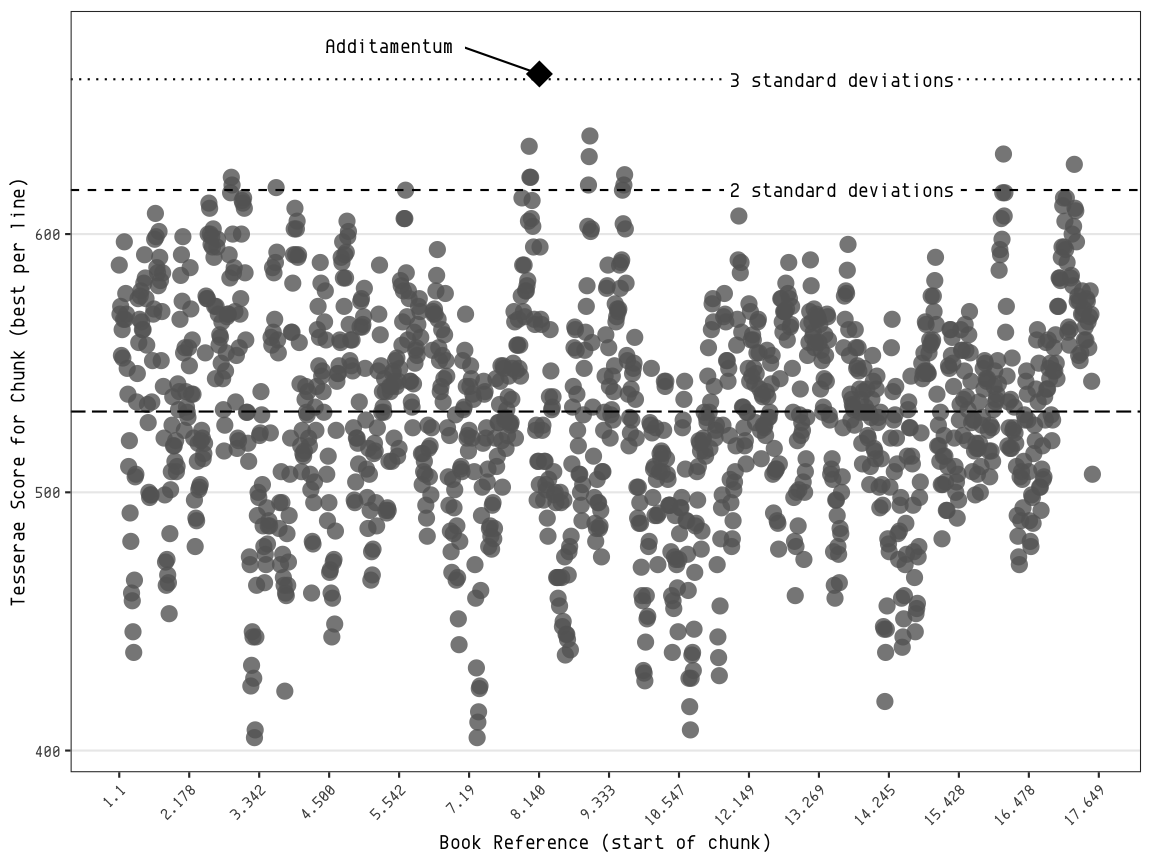

In [35]:
%%R -i best_summed_na,breaks,labs,addit_y_best,h95_best,h99_best,mean_best -h 6 -w 8 -u in -r 144

library(ggplot2)
library(ggrepel)
#library(extrafont) 

ggplot(data=best_summed_na,aes(x=L,y=score)) +
geom_point(color='grey40', size=3.7, alpha=0.8, shape=16) +

# Add and annotate the data point for the Additamentum
annotate("point", color='black', size=6, alpha=1, shape=18, x=5230, y=addit_y_best) +
annotate("segment", x = 5230 - 1000, xend = 5230, y = addit_y_best + 11, yend = addit_y_best,
  colour = "black") +
geom_label(
    color='black',
    label.size=NA,
    label.padding = unit(0.00, "lines"),
    family="Envy Code R",
    x=5230 - 1800 ,y=addit_y_best + 11,
    label="Additamentum ",
    size=3.5,
    fill="white"
) +

# Add and label the mean, 2σ and 3σ
geom_hline(yintercept=h95_best, linetype="dashed", color = "black") +
geom_hline(yintercept=h99_best, linetype="dotted", color = "black") +
geom_hline(yintercept=mean_best, linetype="longdash", color = "black") +
geom_label(
    color='black',
    label.size=NA,
    size=3.5,
    label.padding = unit(0.1, "lines"),
    family="Envy Code R",
    x=9000 ,y=h99_best,
    label="3 standard deviations",
    fill="white"
) +
geom_label(
    color='black',
    label.size=NA,
    size=3.5,
    label.padding = unit(0.19, "lines"), # HACK to obscure one point that looks ugly with the label text
    family="Envy Code R",
    x=9000 ,y=h95_best,
    label="2 standard deviations",
    fill="white"
) +

# General styling
theme_bw() +
theme(text = element_text(size=10, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
theme(plot.title = element_text(hjust=0.5)) +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
theme(panel.grid.major.x = element_blank()) +
scale_x_continuous(breaks=breaks, labels=labs) +
labs(
    x="Book Reference (start of chunk)",
    y="Tesserae Score for Chunk (best per line)"
)

In [ ]:
# This plot is to verify that the "Vergilianness" scores from Tesserae are
# normally distributed. Without this verification it would be bad practice
# to draw conclusions from the mean and stddev.

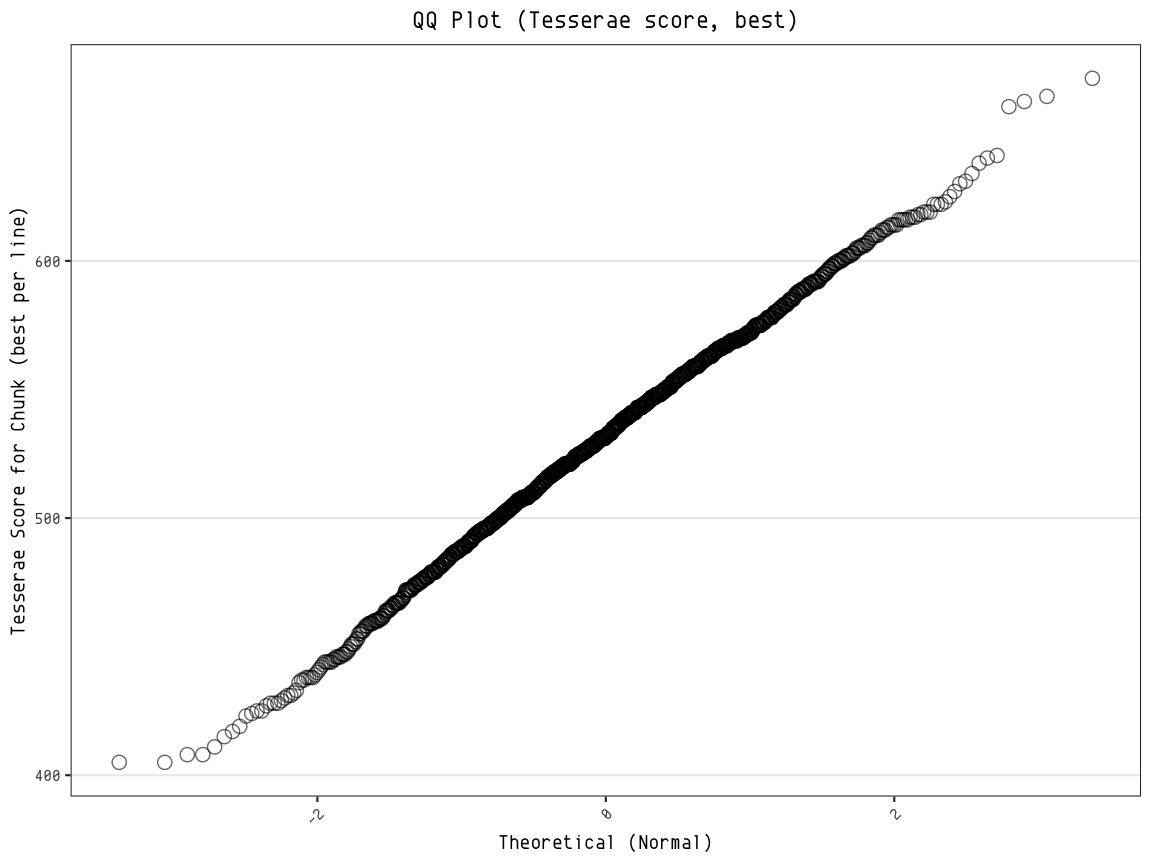

In [31]:
%%R -i best_summed -h 6 -w 8 -u in -r 144

library(ggplot2)
ggplot(best_summed) +
geom_qq(aes(sample = score), color='black', shape=1, alpha=0.6, size=3) +
theme_bw() +
theme(text = element_text(size=10, family="Envy Code R"), panel.grid.minor=element_blank(), legend.title=element_blank()) +
theme(plot.title = element_text(hjust=0.5)) +
theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
theme(panel.grid.major.x = element_blank()) +
labs(
    x="Theoretical (Normal)",
    y="Tesserae Score for Chunk (best per line)",
    title="QQ Plot (Tesserae score, best)"
)